# # 📘 Classical Models for Spam Detection

This notebook trains and compares **two classical ML models** for detecting spam messages:
- Logistic Regression
- Multinomial Naive Bayes

### Imports and Setup

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string


import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB


import warnings
warnings.simplefilter("always")




### Load and Inspect the Dataset

- Load SMS spam dataset and inspect label distribution.

<>:1: DeprecationWarning: invalid escape sequence '\S'
<>:1: DeprecationWarning: invalid escape sequence '\S'
C:\Users\sajid.ali\AppData\Local\Temp\ipykernel_21944\3940619852.py:1: DeprecationWarning: invalid escape sequence '\S'
  df = pd.read_csv('D:\Sajid\email-spam-detection/data/spam.csv', encoding='latin-1')
C:\Users\sajid.ali\AppData\Local\Temp\ipykernel_21944\3940619852.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


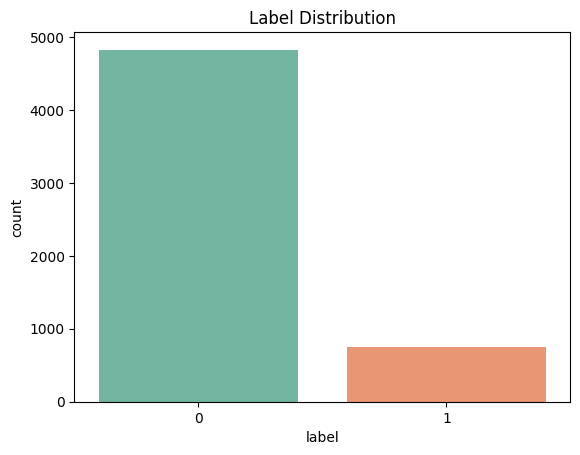

In [15]:
df = pd.read_csv('D:\Sajid\email-spam-detection/data/spam.csv', encoding='latin-1')


df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})

# Label encoding: ham = 0, spam = 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Visualize label distribution
sns.countplot(x='label', data=df, palette='Set2')
plt.title("Label Distribution")
plt.show()

### Data Preprocessing

In [16]:
# Check for missing values
print("\nMissing values:\n")
print(df.isnull().sum(),'\n')


print(f"Shape Raw data: {df.shape}")




# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# If duplicates exist, drop them
df = df.drop_duplicates()


print(f"Shape after removing duplicates: {df.shape}")




Missing values:

label    0
text     0
dtype: int64 

Shape Raw data: (5572, 2)

Number of duplicate rows: 403
Shape after removing duplicates: (5169, 2)


### Basic Text Cleaning
- convert the text into lower case
- remove digits, punctuations, extra spaces, special characters etc

In [17]:
def basic_clean(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove all special characters except letters and numbers
    text = text.encode('ascii', 'ignore').decode('utf-8')  # Remove non-ASCII characters

    return text



In [18]:

df['clean_text'] = df['text'].apply(basic_clean)

df[['text', 'clean_text']].head()

,text,clean_text
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


### Tokenization & Stopword Removal

- Split text into individual words (tokens)
- Remove common uninformative words like "the", "is", "and", etc.

In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

# Apply to cleaned text
df['clean_text'] = df['clean_text'].apply(remove_stopwords)


df[['text', 'clean_text']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sajid.ali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


### Text Vectorization : 
- converting words into numerical features that ML models can understand --> ITF-IDF Vectorization
- High TF-IDF score = strong signal word → Likely important for classification, clustering, search ranking, etc.


In [20]:


# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=3000,         # Keep only the top 3000 important words
    stop_words='english',      # Remove common English stopwords (in case some are still there)
    ngram_range=(1, 2)         # Use unigrams (you can change to (1, 2) for unigrams + bigrams)
)

# Fit and transform the clean text
X = tfidf.fit_transform(df['clean_text'])

# Convert to DataFrame (optional, for inspection)
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())

# Show sample rows of the resulting TF-IDF matrix
tfidf_df.head()

#print(X)


,aah,abi,abiola,able,abt,ac,acc,accept,access,accidentally,...,yr,yr prize,yrs,yummy,yun,yup,yup im,yup ok,yup thk,zed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TF-IDF Feature Interpretation: Top Important Words
- Identify words with highest average TF-IDF score across all messages

In [21]:
# Calculate average TF-IDF score for each word
avg_tfidf_scores = tfidf_df.mean(axis=0).sort_values(ascending=False)

# Convert to DataFrame for inspection
important_words = avg_tfidf_scores.reset_index()
important_words.columns = ['word', 'avg_tfidf_score']

# View top words
important_words.head(5)


,word,avg_tfidf_score
0,im,0.019520
1,ok,0.015584
2,dont,0.012639
3,come,0.012394
4,ltgt,0.012350


In [23]:
df.head()

,label,text,clean_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


### Train-Test Split

- Split data into training and testing sets with stratified sampling.

In [25]:
# X = TF-IDF features, y = target labels
y = df['label']

# Split TF-IDF matrix (X) and labels (y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Check shapes
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (4135, 3000)
Test shape: (1034, 3000)


## Logistic Regression
- Train and evaluate a Logistic Regression model.

In [27]:
# Initialize the model with balanced class weights
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Train the model
lr.fit(X_train, y_train)

# Predict on test set
y_pred = lr.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9729206963249516

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       903
           1       0.91      0.87      0.89       131

    accuracy                           0.97      1034
   macro avg       0.95      0.93      0.94      1034
weighted avg       0.97      0.97      0.97      1034


Confusion Matrix:
 [[892  11]
 [ 17 114]]


### Grid Search for Logistic Regression

- Use GridSearchCV to tune Logistic Regression hyperparameters.

In [28]:

# 1. Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],                 # Regularization strength
    #'penalty': ['l2','l1'],                      # penalty
    'solver': ['lbfgs','liblinear'],         # Solver for l2
    'class_weight': ['balanced', None,{0: 1, 1: 5},{0: 1, 1: 10}],     # To handle imbalance
    'max_iter': [100,500, 1000]                 # Allow enough iterations to converge
}

# 2. Initialize base model
lr = LogisticRegression()

# 3. Grid Search
grid = GridSearchCV(estimator=lr, param_grid=param_grid,
                    scoring='f1', cv=5, n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)



Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': ['balanced', None, {0: 1, 1: 5},
                                          {0: 1, 1: 10}],
                         'max_iter': [100, 500, 1000],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='f1', verbose=1)

In [29]:
#Best model
best_lr_model = grid.best_estimator_
print("Best Parameters:\n", grid.best_params_)

#Predict on test set
y_pred = best_lr_model.predict(X_test)

#Evaluation
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Best Parameters:
 {'C': 10, 'class_weight': {0: 1, 1: 10}, 'max_iter': 100, 'solver': 'lbfgs'}

Accuracy: 0.9729206963249516

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       903
           1       0.91      0.88      0.89       131

    accuracy                           0.97      1034
   macro avg       0.94      0.93      0.94      1034
weighted avg       0.97      0.97      0.97      1034


Confusion Matrix:
 [[891  12]
 [ 16 115]]


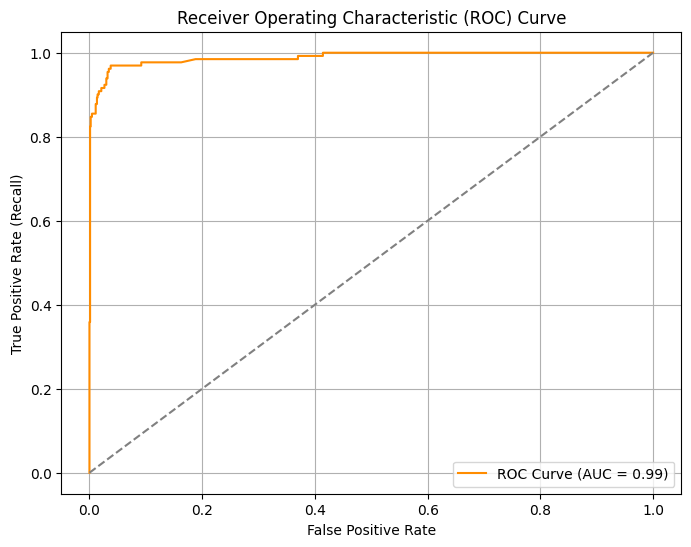

In [30]:


# Get predicted probabilities for the positive class (spam = 1)
y_probs = best_lr_model.predict_proba(X_test)[:, 1]

# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute AUC score
auc_score = roc_auc_score(y_test, y_probs)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### feature interpretation

- Understand which words (features) were most influential in predicting spam vs. ham.

In [31]:
feature_names = tfidf.get_feature_names_out()
coefficients = best_lr_model.coef_[0]


coef_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients
})


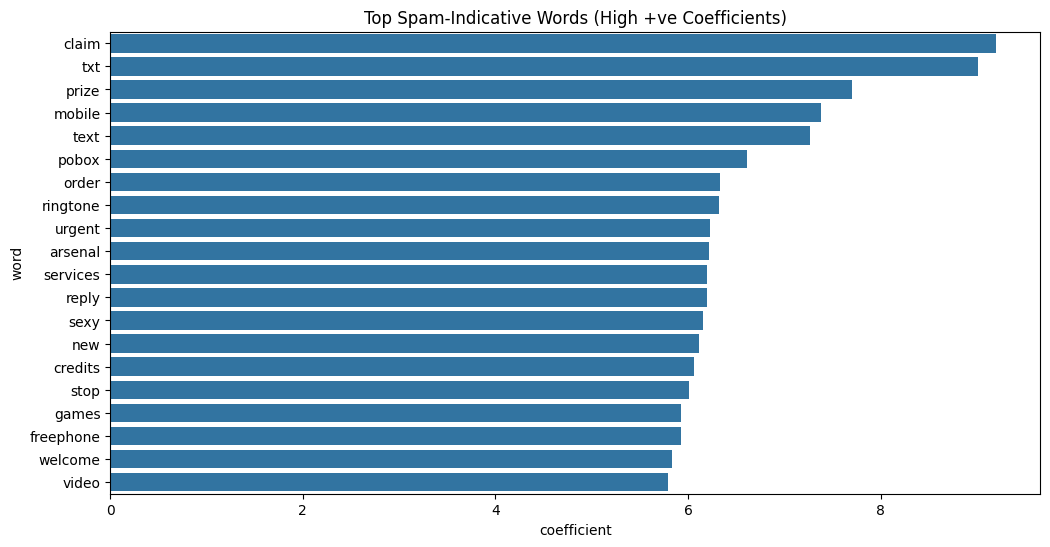

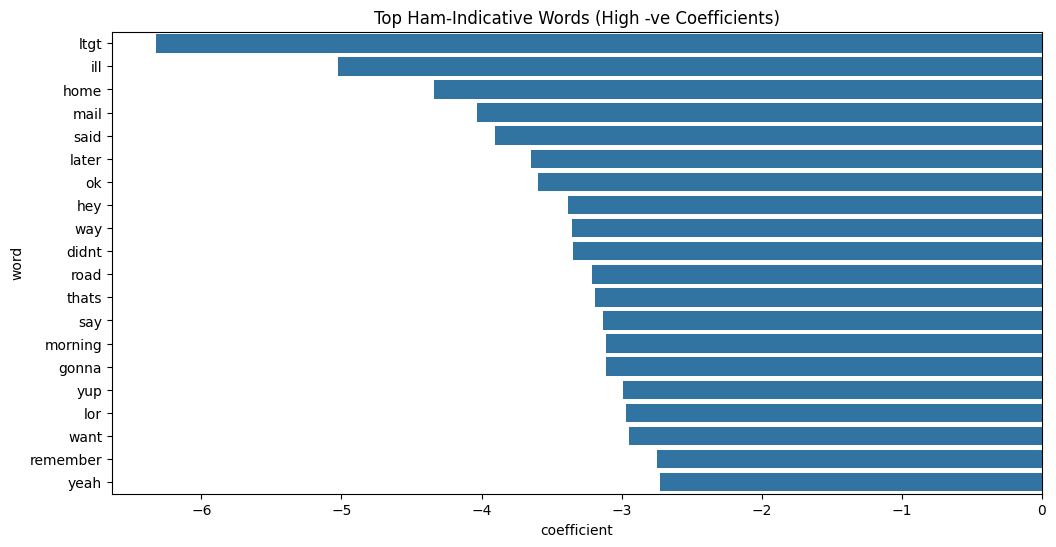

In [32]:
# Top spam-indicating words
top_spam = coef_df.sort_values(by='coefficient', ascending=False).head(20)

# Top ham-indicating words
top_ham = coef_df.sort_values(by='coefficient', ascending=True).head(20)



plt.figure(figsize=(12, 6))
sns.barplot(x='coefficient', y='word', data=top_spam)
plt.title('Top Spam-Indicative Words (High +ve Coefficients)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='coefficient', y='word', data=top_ham)
plt.title('Top Ham-Indicative Words (High -ve Coefficients)')
plt.show()



### Naive Bayes (MultinomialNB) on TF-IDF features
- Train and evaluate a Multinomial Naive Bayes model.

In [35]:
# Initialize and train the Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train, y_train)


# Predict on test data
y_pred_nb = nb.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Accuracy: 0.971953578336557

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       903
           1       0.99      0.79      0.88       131

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034


Confusion Matrix:
 [[902   1]
 [ 28 103]]


In [36]:
# Define parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 2.0, 5.0]
}

# Initialize and run GridSearchCV
nb = MultinomialNB()
grid = GridSearchCV(nb, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 2.0, 5.0]},
             scoring='f1', verbose=1)

### ### Grid Search for Naive Bayes

- Use GridSearchCV to tune Logistic Regression hyperparameters.

In [37]:
# Get best model
best_nb = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Predict and evaluate
y_pred_nb_best = best_nb.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred_nb_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb_best))

Best Parameters: {'alpha': 0.3}
Accuracy: 0.9777562862669246

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.97      0.85      0.91       131

    accuracy                           0.98      1034
   macro avg       0.98      0.92      0.95      1034
weighted avg       0.98      0.98      0.98      1034


Confusion Matrix:
 [[900   3]
 [ 20 111]]
